In [1]:
# %%writefile image_util.py

import torch.nn as nn
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, save, load, from_numpy
import numpy as np

import cv2 as cv
import os

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 128) # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

from PIL import Image, ImageOps
def pad_img(img):
    desired_sz = 32
    w, h = img.size
    resize_ratio = desired_sz * 1.0 / max(w, h)
    img = img.resize((int(w*resize_ratio), int(h*resize_ratio)))
    
    #pad image to make 32x32
    w, h = img.size
    delta_w = desired_sz - w
    delta_h = desired_sz - h
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(
        img, 
        padding
    )

def proc_fn(x):
    return transforms.Normalize([0.5], [0.5])(transforms.ToTensor()(x.convert('L')))

def preproc_pil_img(img):
    # gray, norm, tensor
    return proc_fn(pad_img(img))

def file2tensor(file_path):
    aa = preproc_pil_img(Image.open(file_path))
    c, w, h = aa.size()
    aa = aa.view((1, c, w, h))
    return aa

def cv2tensor(img):
    if len(img.shape) > 2:
        img = cv.cvtColor(img,cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)
    aa = preproc_pil_img(pil_img)
    c, w, h = aa.size()
    aa = aa.view((1, c, w, h))
    return aa
    
def predict_image(tensor, model):
    output = model(Variable(tensor))
    return np.exp(output.data.numpy())
#     print(np.exp(output.data.numpy()))
#     return np.argmax(output.data.numpy(), axis=1)

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# the folder is structured in the following way:
#     -- data_folder
#         -- label1
#             -- image1
#             -- image2
#             -- ..
#         -- label2
#             -- image1
#             -- ..
#         -- ..
class LabeledDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data = []
        # the number of data for each label should be similar
        cap = self._calc_sample_cap(data_folder)
        for x in os.listdir(data_folder):
            # list label folders
            x_path = os.path.join(data_folder, x)
            if os.path.isdir(x_path):
                # list images in label folder
                for y in os.listdir(x_path)[:cap]:
                    if self._is_img(y):
                        img = Image.open(os.path.join(x_path, y))
                        self.data.append((transform(img), int(x)))

    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        #这里需要注意的是，第一步：read one data，是一个data
        return self.data[index]
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.data)
    
    def _is_img(self, file_path):
        return any([file_path.endswith(ext) for ext in ('.jpg', '.jpeg', '.png')])
    
    def _calc_sample_cap(self, folder):
        return min([len(os.listdir(os.path.join(folder, dire))) for dire in os.listdir(folder) if os.path.isdir(os.path.join(folder, dire))])
        
        

In [60]:
# copy from original data source to cropped labeled folder
from digitStruct import *
root = '/Users/jtao/Downloads/extra'
dsFileName = os.path.join(root, 'digitStruct.mat')
data_agg = root + '_agg'
if not os.path.exists(data_agg):
    os.mkdir(data_agg)
testCounter = 0
for dsObj in yieldNextDigitStruct(dsFileName):
    break
    testCounter += 1
    if testCounter < 132000: continue
    if not testCounter % 1000:
        print(testCounter)
#     print(dsObj.name)
    img_file_path = os.path.join(root, dsObj.name)
    img = Image.open(img_file_path)
    for bbox in dsObj.bboxList:
#         print("    {}:{},{},{},{}".format(
#             bbox.label, bbox.left, bbox.top, bbox.width, bbox.height))
        try:
            label_dir = os.path.join(data_agg, str(bbox.label))
            if not os.path.exists(label_dir):
                os.mkdir(label_dir)
            cropped = img.crop((bbox.left, bbox.top, bbox.left+bbox.width, bbox.top+bbox.height))
            padded = pad_img(cropped)
            padded.save(os.path.join(label_dir, str(dsObj.name) + '_' + str(bbox.left) + '_' + str(bbox.top) + '.png'))
        except:
            print('skipping a defect')
            continue
        
    

132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000
195000
196000
197000
198000
199000
200000
201000
202000


In [4]:
pwd = %pwd
proc_fn = lambda x: transforms.Normalize([0.5], [0.5])(transforms.ToTensor()(x.convert('L')))
# data = SVHN(
#     pwd, 
#     download=True, 
#     transform=proc_fn,
# )
data = LabeledDataset('/Users/jtao/Downloads/extra_agg/', transform=proc_fn)
# np.place(data.labels, data.labels == 10, 0)

In [5]:
pwd = %pwd
# test = SVHN(
#     pwd, 
#     split='test',
#     download=True, 
#     transform=proc_fn,
# )
test = LabeledDataset('/Users/jtao/Downloads/test_agg/', transform=proc_fn)
# np.place(test.labels, test.labels == 10, 0)

In [6]:
len([d for d in data if d[1] == 0])
# data._calc_sample_cap('/Users/jtao/Downloads/extra_agg/')

34397

In [7]:
train_loader = DataLoader(dataset=data,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)
test_loader = DataLoader(dataset=test,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)

In [12]:
len(data)

530301

In [8]:
# 迭代开始，然后，队列和线程跟着也开始
data_iter = iter(train_loader)

# mini-batch 图像 和 标签
images, labels = next(data_iter)

Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jtao/miniconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/jtao/miniconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/Users/jtao/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Users/jtao/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/Users/jtao/miniconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
  File "/Users/jtao/miniconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/Users/jtao/miniconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/Users/j

In [9]:
labels


 4
 0
 7
 0
 1
 3
 2
 2
 9
 2
 9
 0
 6
 9
 6
 8
 0
 9
 7
 6
 2
 7
 9
 8
 1
 5
 7
 5
 9
 7
 1
 3
 6
 0
 9
 9
 3
 0
 0
 1
 2
 7
 2
 3
 5
 4
 5
 8
 8
 8
 6
 0
 1
 0
 5
 9
 5
 3
 7
 4
 9
 4
 8
 4
 1
 9
 4
 4
 9
 8
 3
 1
 2
 1
 9
 6
 5
 1
 8
 2
 7
 4
 2
 0
 0
 9
 9
 3
 5
 9
 3
 4
 0
 0
 4
 5
 0
 5
 3
 3
[torch.LongTensor of size 100]

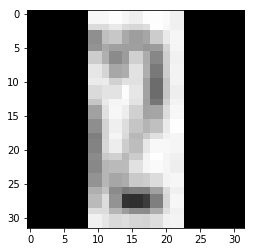

In [43]:
plt.imshow(images[9].numpy()[0], cmap='gray')

In [16]:
def error_rate(loader, model, sample_rate=0.1):
    err = []
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx > len(loader) * sample_rate: break
        output = net(Variable(images))
        output = np.argmax(output.data.numpy(), axis=1)
        err.append(np.sum(output != labels.squeeze().numpy()) * 1.0 / len(output))
    return np.mean(err)

        
net = Net()
# data_iter = iter(train_loader)

# mini-batch 图像 和 标签
# images, labels = next(data_iter)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01)
num_epoch = 1000

pwd = %pwd
model_folder = os.path.join(pwd, 'vanilla_extra')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
else:
    print('Overwriting existing models')
test_acc_arr = []

# in your training loop:
for i in range(num_epoch):
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad() # zero the gradient buffers，如果不归0的话，gradients会累加

        output = net(Variable(images)) # 这里就体现出来动态建图了，你还可以传入其他的参数来改变网络的结构\
        target = Variable(labels).squeeze().long()
        
#         print(output)
#         print(target)
        loss = F.nll_loss(output, target)
        loss.backward() # 得到grad，i.e.给Variable.grad赋值
        optimizer.step() # Does the update，i.e. Variable.data -= learning_rate*Variable.grad

        if not batch_idx % 300:
            print('Epoch {} batch {}: loss {}'.format(i, batch_idx, loss))
            print('Training acc: {}'.format(1.0 - error_rate(train_loader, net)))
    test_acc = 1.0 - error_rate(test_loader, net)
    print('Test acc: {}'.format(test_acc))
    test_acc_arr.append(test_acc)
    if test_acc > 0.6:
        save(net, '{}/epoch_{}.pkl'.format(model_folder, i))
        if len(test_acc_arr) > 3 and test_acc_arr[-1] < test_acc_arr[-2] < test_acc_arr[-3] < test_acc_arr[-4]:
            print('Test acc going down consecutively 3 times, stop training')
            break


Epoch 0 batch 0: loss Variable containing:
 2.3039
[torch.FloatTensor of size 1]

Training acc: 0.0999710144928
Epoch 0 batch 300: loss Variable containing:
 2.3071
[torch.FloatTensor of size 1]

Training acc: 0.101420289855
Epoch 0 batch 600: loss Variable containing:
 2.2990
[torch.FloatTensor of size 1]

Training acc: 0.104057971014
Epoch 0 batch 900: loss Variable containing:
 2.3002
[torch.FloatTensor of size 1]

Training acc: 0.122376811594
Epoch 0 batch 1200: loss Variable containing:
 2.3042
[torch.FloatTensor of size 1]

Training acc: 0.10684057971
Epoch 0 batch 1500: loss Variable containing:
 2.3004
[torch.FloatTensor of size 1]

Training acc: 0.118608695652
Epoch 0 batch 1800: loss Variable containing:
 2.3001
[torch.FloatTensor of size 1]

Training acc: 0.146637681159
Epoch 0 batch 2100: loss Variable containing:
 2.2995
[torch.FloatTensor of size 1]

Training acc: 0.163043478261
Epoch 0 batch 2400: loss Variable containing:
 2.2981
[torch.FloatTensor of size 1]

Training 

/Users/jtao/miniconda2/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 3 batch 0: loss Variable containing:
 0.5046
[torch.FloatTensor of size 1]

Training acc: 0.835246376812
Epoch 3 batch 300: loss Variable containing:
 0.4285
[torch.FloatTensor of size 1]

Training acc: 0.827507246377
Epoch 3 batch 600: loss Variable containing:
 0.4340
[torch.FloatTensor of size 1]

Training acc: 0.855101449275
Epoch 3 batch 900: loss Variable containing:
 0.4313
[torch.FloatTensor of size 1]

Training acc: 0.850463768116
Epoch 3 batch 1200: loss Variable containing:
 0.7829
[torch.FloatTensor of size 1]

Training acc: 0.856637681159
Epoch 3 batch 1500: loss Variable containing:
 0.3217
[torch.FloatTensor of size 1]

Training acc: 0.867217391304
Epoch 3 batch 1800: loss Variable containing:
 0.4033
[torch.FloatTensor of size 1]

Training acc: 0.872637681159
Epoch 3 batch 2100: loss Variable containing:
 0.4228
[torch.FloatTensor of size 1]

Training acc: 0.875188405797
Epoch 3 batch 2400: loss Variable containing:
 0.4046
[torch.FloatTensor of size 1]

Training 

Training acc: 0.926115942029
Test acc: 0.838823529412
Epoch 9 batch 0: loss Variable containing:
 0.1606
[torch.FloatTensor of size 1]

Training acc: 0.926492753623
Epoch 9 batch 300: loss Variable containing:
 0.1772
[torch.FloatTensor of size 1]

Training acc: 0.933043478261
Epoch 9 batch 600: loss Variable containing:
 0.1918
[torch.FloatTensor of size 1]

Training acc: 0.931739130435
Epoch 9 batch 900: loss Variable containing:
 0.2520
[torch.FloatTensor of size 1]

Training acc: 0.930608695652
Epoch 9 batch 1200: loss Variable containing:
 0.2349
[torch.FloatTensor of size 1]

Training acc: 0.931275362319
Epoch 9 batch 1500: loss Variable containing:
 0.3874
[torch.FloatTensor of size 1]

Training acc: 0.932927536232
Epoch 9 batch 1800: loss Variable containing:
 0.1408
[torch.FloatTensor of size 1]

Training acc: 0.93252173913
Epoch 9 batch 2100: loss Variable containing:
 0.2966
[torch.FloatTensor of size 1]

Training acc: 0.933275362319
Epoch 9 batch 2400: loss Variable contain

Epoch 14 batch 3000: loss Variable containing:
 0.1287
[torch.FloatTensor of size 1]

Training acc: 0.949101449275
Epoch 14 batch 3300: loss Variable containing:
 0.1618
[torch.FloatTensor of size 1]

Training acc: 0.947449275362
Test acc: 0.863529411765
Epoch 15 batch 0: loss Variable containing:
 0.1966
[torch.FloatTensor of size 1]

Training acc: 0.944434782609
Epoch 15 batch 300: loss Variable containing:
1.00000e-02 *
  7.3047
[torch.FloatTensor of size 1]

Training acc: 0.949826086957
Epoch 15 batch 600: loss Variable containing:
 0.1287
[torch.FloatTensor of size 1]

Training acc: 0.949884057971
Epoch 15 batch 900: loss Variable containing:
 0.1282
[torch.FloatTensor of size 1]

Training acc: 0.948347826087
Epoch 15 batch 1200: loss Variable containing:
 0.1014
[torch.FloatTensor of size 1]

Training acc: 0.943768115942
Epoch 15 batch 1500: loss Variable containing:
 0.1993
[torch.FloatTensor of size 1]

Training acc: 0.948231884058
Epoch 15 batch 1800: loss Variable containing:

Epoch 20 batch 2100: loss Variable containing:
 0.3180
[torch.FloatTensor of size 1]

Training acc: 0.957188405797
Epoch 20 batch 2400: loss Variable containing:
 0.2999
[torch.FloatTensor of size 1]

Training acc: 0.953014492754
Epoch 20 batch 2700: loss Variable containing:
 0.1030
[torch.FloatTensor of size 1]

Training acc: 0.952695652174
Epoch 20 batch 3000: loss Variable containing:
 0.1775
[torch.FloatTensor of size 1]

Training acc: 0.953362318841
Epoch 20 batch 3300: loss Variable containing:
 0.1761
[torch.FloatTensor of size 1]

Training acc: 0.958492753623
Test acc: 0.876470588235
Epoch 21 batch 0: loss Variable containing:
 0.1588
[torch.FloatTensor of size 1]

Training acc: 0.954898550725
Epoch 21 batch 300: loss Variable containing:
 0.1995
[torch.FloatTensor of size 1]

Training acc: 0.956376811594
Epoch 21 batch 600: loss Variable containing:
 0.1315
[torch.FloatTensor of size 1]

Training acc: 0.952666666667
Epoch 21 batch 900: loss Variable containing:
 0.1981
[torch

Training acc: 0.959304347826
Epoch 26 batch 1200: loss Variable containing:
 0.2148
[torch.FloatTensor of size 1]

Training acc: 0.960811594203
Epoch 26 batch 1500: loss Variable containing:
 0.1160
[torch.FloatTensor of size 1]

Training acc: 0.956869565217
Epoch 26 batch 1800: loss Variable containing:
 0.2217
[torch.FloatTensor of size 1]

Training acc: 0.957565217391
Epoch 26 batch 2100: loss Variable containing:
 0.1432
[torch.FloatTensor of size 1]

Training acc: 0.961072463768
Epoch 26 batch 2400: loss Variable containing:
1.00000e-02 *
  5.0451
[torch.FloatTensor of size 1]

Training acc: 0.961710144928
Epoch 26 batch 2700: loss Variable containing:
 0.1577
[torch.FloatTensor of size 1]

Training acc: 0.958144927536
Epoch 26 batch 3000: loss Variable containing:
 0.1781
[torch.FloatTensor of size 1]

Training acc: 0.959130434783
Epoch 26 batch 3300: loss Variable containing:
 0.1453
[torch.FloatTensor of size 1]

Training acc: 0.960608695652
Test acc: 0.887647058824
Epoch 27 ba

In [51]:
import torch
torch.__version__

'0.2.0_4'

In [72]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
# model = load('vanilla_model_epoch_60.pkl')
model = load('vanilla_extra/epoch_25.pkl')

In [35]:
tensor = file2tensor('clocks/num11.png')
out = predict_image(tensor, model)
print(out)
print(np.argmax(out, axis=1))

[[3.9966962e-01 4.3190708e-03 5.7844732e-06 1.7083448e-01 1.5318108e-04
  1.7029230e-03 3.3075842e-01 3.7784437e-03 8.3629519e-02 5.1485528e-03]]
[0]


In [24]:
np.exp([0, 1])

array([ 1.        ,  2.71828183])

In [23]:
aa = np.random.rand(3, 4)
aa

array([[0.18172115, 0.81269883, 0.30181448, 0.8013887 ],
       [0.51834583, 0.0633119 , 0.1472658 , 0.07491638],
       [0.46951932, 0.97698501, 0.54223489, 0.23656321]])

In [24]:
np.argmax(aa, axis=0)

array([1, 2, 2, 0])

In [21]:
map(lambda x:x+1, [1,2])

[2, 3]

In [9]:
img = Image.open('/Users/jtao/Downloads/train/1.png')

In [13]:
croped = img.crop((246,77,246+81,77+219))

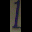

In [14]:
pad_img(croped)

In [61]:
import os
root = '/Users/jtao/Downloads/extra_agg'
for dire in os.listdir(root):
    dire = os.path.join(root, dire)
    if os.path.isdir(dire):
        print('{} has {} files'.format(dire, len(os.listdir(dire))))

/Users/jtao/Downloads/extra_agg/9 has 34397 files
/Users/jtao/Downloads/extra_agg/7 has 43931 files
/Users/jtao/Downloads/extra_agg/6 has 41503 files
/Users/jtao/Downloads/extra_agg/1 has 90435 files
/Users/jtao/Downloads/extra_agg/10 has 45496 files
/Users/jtao/Downloads/extra_agg/8 has 35293 files
/Users/jtao/Downloads/extra_agg/4 has 50553 files
/Users/jtao/Downloads/extra_agg/3 has 60655 files
/Users/jtao/Downloads/extra_agg/2 has 74631 files
/Users/jtao/Downloads/extra_agg/5 has 53407 files


In [ ]:
/Users/jtao/Downloads/train_agg/9 has 4659 files
/Users/jtao/Downloads/train_agg/0 has 4948 files
/Users/jtao/Downloads/train_agg/7 has 5595 files
/Users/jtao/Downloads/train_agg/6 has 5727 files
/Users/jtao/Downloads/train_agg/1 has 13861 files
/Users/jtao/Downloads/train_agg/8 has 5045 files
/Users/jtao/Downloads/train_agg/4 has 7458 files
/Users/jtao/Downloads/train_agg/3 has 8497 files
/Users/jtao/Downloads/train_agg/2 has 10585 files
/Users/jtao/Downloads/train_agg/5 has 6882 files